In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has three classes: whether stock will go up, down or stay constant X days after last input.

Story: Investor observes stock for 60 days. Then decides whether buy some stocks and sell it after 10 days. Therefore input consist of stock prices from day 1st to 60th, output is:
* -1 if price will go down by more than 1%, 
* 0 if price will not go up or down by more than 1% 
* 1 if price will go up by more than 1%

Relative change output is calculated using the following formula: (opening_price_on_buyout_day -closing_price_on_last_day_of_observation) / opening_price_on_buyout_day * 100%

Based on percentage value from formula above, label will be calculated.

In [1]:
OBSERVATION_TIME = 60
PREDICTION_AFTER_DAYS = 10
PERCENTAGE_THRESHOLD = 0.5
EPOCHS = 2000
TEST_SIZE = 0.40
RANDOM_SPLIT = False

In [2]:
import pandas as pd

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [3]:
def percentage_to_label(percentage_value):
    return -1 if percentage_value < -PERCENTAGE_THRESHOLD else 0 if percentage_value <= PERCENTAGE_THRESHOLD else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0].head(5)

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


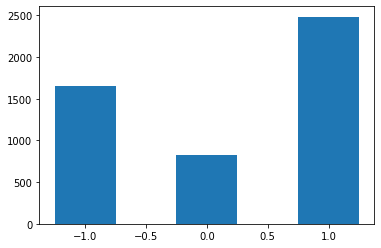

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results, bins=[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25])
plt.show()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [6]:
import numpy as np
from keras.utils import to_categorical

def categorical_labels(label_array):
    return to_categorical(list(map(lambda x: x + 1, label_array)))

categorical_labels(observation_results)

Using TensorFlow backend.


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [7]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (60, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 16)            336       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 8)             520       
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 8)            

In [8]:
from keras.optimizers import Nadam

model.compile(optimizer=Nadam(lr=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(categorical_labels(observation_results))

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2976, 60, 5), (2976, 3), (1984, 60, 5), (1984, 3))

In [10]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [reduce_lr, checkpointer])

Train on 2976 samples, validate on 1984 samples
Epoch 1/2000
2976/2976 [==============================] - 1s 307us/step - loss: 1.1903 - accuracy: 0.3810 - val_loss: 3.1304 - val_accuracy: 0.5192

Epoch 00001: val_loss improved from inf to 3.13036, saving model to model.hdf5
Epoch 2/2000
2304/2976 [======================>.......] - ETA: 0s - loss: 1.0744 - accuracy: 0.4379

/Users/mateusz.kuzmik/university/trading-xai/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2976/2976 [==============================] - 0s 92us/step - loss: 1.0631 - accuracy: 0.4476 - val_loss: 5.6301 - val_accuracy: 0.4929

Epoch 00002: val_loss did not improve from 3.13036
Epoch 3/2000
2976/2976 [==============================] - 0s 89us/step - loss: 1.0317 - accuracy: 0.4503 - val_loss: 3.1900 - val_accuracy: 0.2656

Epoch 00003: val_loss did not improve from 3.13036
Epoch 4/2000
2976/2976 [==============================] - 0s 84us/step - loss: 1.0295 - accuracy: 0.4432 - val_loss: 7.5506 - val_accuracy: 0.2656

Epoch 00004: val_loss did not improve from 3.13036
Epoch 5/2000
2976/2976 [==============================] - 0s 81us/step - loss: 1.0159 - accuracy: 0.4654 - val_loss: 4.5549 - val_accuracy: 0.2656

Epoch 00005: val_loss did not improve from 3.13036
Epoch 6/2000
2976/2976 [==============================] - 0s 80us/step - loss: 1.0142 - accuracy: 0.4661 - val_loss: 1.3031 - val_accuracy: 0.2656

Epoch 00006: val_loss improved from 3.13036 to 1.30306, saving model 

2976/2976 [==============================] - 0s 79us/step - loss: 0.9772 - accuracy: 0.4882 - val_loss: 1.1574 - val_accuracy: 0.5192

Epoch 00042: val_loss did not improve from 1.02439
Epoch 43/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.9792 - accuracy: 0.4943 - val_loss: 1.2351 - val_accuracy: 0.3100

Epoch 00043: val_loss did not improve from 1.02439
Epoch 44/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9807 - accuracy: 0.4782 - val_loss: 1.0920 - val_accuracy: 0.5096

Epoch 00044: val_loss did not improve from 1.02439
Epoch 45/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.9774 - accuracy: 0.4923 - val_loss: 1.2409 - val_accuracy: 0.3886

Epoch 00045: val_loss did not improve from 1.02439
Epoch 46/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9747 - accuracy: 0.4980 - val_loss: 1.2099 - val_accuracy: 0.2802

Epoch 00046: val_loss did not improve from 1.02439
Epoch 47/2000


2976/2976 [==============================] - 0s 78us/step - loss: 0.9705 - accuracy: 0.5060 - val_loss: 2.3173 - val_accuracy: 0.4612

Epoch 00083: val_loss did not improve from 1.02439
Epoch 84/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9645 - accuracy: 0.5101 - val_loss: 3.1265 - val_accuracy: 0.5192

Epoch 00084: val_loss did not improve from 1.02439
Epoch 85/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.9662 - accuracy: 0.5144 - val_loss: 1.1164 - val_accuracy: 0.5192

Epoch 00085: val_loss did not improve from 1.02439
Epoch 86/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.9600 - accuracy: 0.5118 - val_loss: 2.1068 - val_accuracy: 0.5156

Epoch 00086: val_loss did not improve from 1.02439
Epoch 87/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9713 - accuracy: 0.5017 - val_loss: 2.1682 - val_accuracy: 0.2656

Epoch 00087: val_loss did not improve from 1.02439
Epoch 88/2000


2976/2976 [==============================] - 0s 83us/step - loss: 0.9464 - accuracy: 0.5323 - val_loss: 1.9862 - val_accuracy: 0.2923

Epoch 00124: val_loss did not improve from 1.02439
Epoch 125/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9470 - accuracy: 0.5393 - val_loss: 1.4460 - val_accuracy: 0.2984

Epoch 00125: val_loss did not improve from 1.02439
Epoch 126/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9495 - accuracy: 0.5323 - val_loss: 1.5323 - val_accuracy: 0.3120

Epoch 00126: val_loss did not improve from 1.02439
Epoch 127/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9433 - accuracy: 0.5423 - val_loss: 3.8067 - val_accuracy: 0.2495

Epoch 00127: val_loss did not improve from 1.02439
Epoch 128/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9476 - accuracy: 0.5383 - val_loss: 1.1625 - val_accuracy: 0.3014

Epoch 00128: val_loss did not improve from 1.02439
Epoch 129/

2976/2976 [==============================] - 0s 79us/step - loss: 0.9190 - accuracy: 0.5672 - val_loss: 2.8871 - val_accuracy: 0.2656

Epoch 00165: val_loss did not improve from 1.02439
Epoch 166/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9163 - accuracy: 0.5618 - val_loss: 2.0557 - val_accuracy: 0.3382

Epoch 00166: val_loss did not improve from 1.02439
Epoch 167/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9049 - accuracy: 0.5766 - val_loss: 1.5719 - val_accuracy: 0.2818

Epoch 00167: val_loss did not improve from 1.02439
Epoch 168/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9122 - accuracy: 0.5746 - val_loss: 1.1461 - val_accuracy: 0.5030

Epoch 00168: val_loss did not improve from 1.02439
Epoch 169/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9182 - accuracy: 0.5689 - val_loss: 1.8934 - val_accuracy: 0.3085

Epoch 00169: val_loss did not improve from 1.02439
Epoch 170/

2976/2976 [==============================] - 0s 82us/step - loss: 0.8850 - accuracy: 0.5890 - val_loss: 1.7139 - val_accuracy: 0.4738

Epoch 00206: val_loss did not improve from 1.02439
Epoch 207/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.8806 - accuracy: 0.5894 - val_loss: 1.4193 - val_accuracy: 0.4682

Epoch 00207: val_loss did not improve from 1.02439
Epoch 208/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.8847 - accuracy: 0.5971 - val_loss: 1.8174 - val_accuracy: 0.3367

Epoch 00208: val_loss did not improve from 1.02439
Epoch 209/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.8752 - accuracy: 0.5951 - val_loss: 2.9364 - val_accuracy: 0.2611

Epoch 00209: val_loss did not improve from 1.02439
Epoch 210/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.8814 - accuracy: 0.5974 - val_loss: 2.8047 - val_accuracy: 0.2697

Epoch 00210: val_loss did not improve from 1.02439
Epoch 211/

2976/2976 [==============================] - 0s 77us/step - loss: 0.8480 - accuracy: 0.6132 - val_loss: 1.8578 - val_accuracy: 0.3478

Epoch 00247: val_loss did not improve from 1.02439
Epoch 248/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.8508 - accuracy: 0.6196 - val_loss: 1.3017 - val_accuracy: 0.4526

Epoch 00248: val_loss did not improve from 1.02439
Epoch 249/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.8522 - accuracy: 0.6042 - val_loss: 2.5326 - val_accuracy: 0.5207

Epoch 00249: val_loss did not improve from 1.02439
Epoch 250/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.8566 - accuracy: 0.6166 - val_loss: 2.0647 - val_accuracy: 0.4879

Epoch 00250: val_loss did not improve from 1.02439
Epoch 251/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.8433 - accuracy: 0.6149 - val_loss: 3.7664 - val_accuracy: 0.5071

Epoch 00251: val_loss did not improve from 1.02439
Epoch 252/

2976/2976 [==============================] - 0s 80us/step - loss: 0.8128 - accuracy: 0.6495 - val_loss: 3.9132 - val_accuracy: 0.2757

Epoch 00288: val_loss did not improve from 1.02439
Epoch 289/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8161 - accuracy: 0.6384 - val_loss: 1.6499 - val_accuracy: 0.3463

Epoch 00289: val_loss did not improve from 1.02439
Epoch 290/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8282 - accuracy: 0.6358 - val_loss: 1.7068 - val_accuracy: 0.3952

Epoch 00290: val_loss did not improve from 1.02439
Epoch 291/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8200 - accuracy: 0.6374 - val_loss: 3.0922 - val_accuracy: 0.2959

Epoch 00291: val_loss did not improve from 1.02439
Epoch 292/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8141 - accuracy: 0.6442 - val_loss: 4.0963 - val_accuracy: 0.3548

Epoch 00292: val_loss did not improve from 1.02439
Epoch 293/

2976/2976 [==============================] - 0s 81us/step - loss: 0.7828 - accuracy: 0.6566 - val_loss: 2.1023 - val_accuracy: 0.4037

Epoch 00329: val_loss did not improve from 1.02439
Epoch 330/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.7805 - accuracy: 0.6562 - val_loss: 2.3284 - val_accuracy: 0.4103

Epoch 00330: val_loss did not improve from 1.02439
Epoch 331/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.7717 - accuracy: 0.6731 - val_loss: 2.5258 - val_accuracy: 0.2984

Epoch 00331: val_loss did not improve from 1.02439
Epoch 332/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.7713 - accuracy: 0.6640 - val_loss: 1.6969 - val_accuracy: 0.4078

Epoch 00332: val_loss did not improve from 1.02439
Epoch 333/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.7948 - accuracy: 0.6546 - val_loss: 3.8400 - val_accuracy: 0.2898

Epoch 00333: val_loss did not improve from 1.02439
Epoch 334/

2976/2976 [==============================] - 0s 80us/step - loss: 0.7578 - accuracy: 0.6717 - val_loss: 4.8024 - val_accuracy: 0.4950

Epoch 00370: val_loss did not improve from 1.02439
Epoch 371/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.7651 - accuracy: 0.6757 - val_loss: 3.7661 - val_accuracy: 0.3009

Epoch 00371: val_loss did not improve from 1.02439
Epoch 372/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.7608 - accuracy: 0.6660 - val_loss: 5.9346 - val_accuracy: 0.2712

Epoch 00372: val_loss did not improve from 1.02439
Epoch 373/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.7624 - accuracy: 0.6610 - val_loss: 1.9809 - val_accuracy: 0.2903

Epoch 00373: val_loss did not improve from 1.02439
Epoch 374/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.7499 - accuracy: 0.6761 - val_loss: 3.2757 - val_accuracy: 0.3191

Epoch 00374: val_loss did not improve from 1.02439
Epoch 375/

2976/2976 [==============================] - 0s 79us/step - loss: 0.7303 - accuracy: 0.6872 - val_loss: 2.9459 - val_accuracy: 0.3261

Epoch 00411: val_loss did not improve from 1.02439
Epoch 412/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.7494 - accuracy: 0.6670 - val_loss: 7.4270 - val_accuracy: 0.2243

Epoch 00412: val_loss did not improve from 1.02439
Epoch 413/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.7435 - accuracy: 0.6902 - val_loss: 3.6394 - val_accuracy: 0.2989

Epoch 00413: val_loss did not improve from 1.02439
Epoch 414/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.7289 - accuracy: 0.6878 - val_loss: 7.6396 - val_accuracy: 0.2656

Epoch 00414: val_loss did not improve from 1.02439
Epoch 415/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7454 - accuracy: 0.6791 - val_loss: 4.6078 - val_accuracy: 0.2460

Epoch 00415: val_loss did not improve from 1.02439
Epoch 416/

2976/2976 [==============================] - 0s 76us/step - loss: 0.7078 - accuracy: 0.7019 - val_loss: 2.5143 - val_accuracy: 0.3659

Epoch 00452: val_loss did not improve from 1.02439
Epoch 453/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7097 - accuracy: 0.7006 - val_loss: 3.1665 - val_accuracy: 0.4531

Epoch 00453: val_loss did not improve from 1.02439
Epoch 454/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.7172 - accuracy: 0.6909 - val_loss: 2.6529 - val_accuracy: 0.2964

Epoch 00454: val_loss did not improve from 1.02439
Epoch 455/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7455 - accuracy: 0.6875 - val_loss: 5.5499 - val_accuracy: 0.2686

Epoch 00455: val_loss did not improve from 1.02439
Epoch 456/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7066 - accuracy: 0.6972 - val_loss: 4.0698 - val_accuracy: 0.2863

Epoch 00456: val_loss did not improve from 1.02439
Epoch 457/

2976/2976 [==============================] - 0s 77us/step - loss: 0.7126 - accuracy: 0.6932 - val_loss: 3.9532 - val_accuracy: 0.3322

Epoch 00493: val_loss did not improve from 1.02439
Epoch 494/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.7016 - accuracy: 0.7063 - val_loss: 2.2051 - val_accuracy: 0.3609

Epoch 00494: val_loss did not improve from 1.02439
Epoch 495/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7006 - accuracy: 0.7046 - val_loss: 2.3399 - val_accuracy: 0.3453

Epoch 00495: val_loss did not improve from 1.02439
Epoch 496/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7064 - accuracy: 0.6993 - val_loss: 3.0685 - val_accuracy: 0.4516

Epoch 00496: val_loss did not improve from 1.02439
Epoch 497/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.7036 - accuracy: 0.7087 - val_loss: 4.6101 - val_accuracy: 0.3266

Epoch 00497: val_loss did not improve from 1.02439
Epoch 498/

2976/2976 [==============================] - 0s 83us/step - loss: 0.6852 - accuracy: 0.7087 - val_loss: 6.0428 - val_accuracy: 0.2777

Epoch 00534: val_loss did not improve from 1.02439
Epoch 535/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.6815 - accuracy: 0.7087 - val_loss: 2.9752 - val_accuracy: 0.3564

Epoch 00535: val_loss did not improve from 1.02439
Epoch 536/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.6869 - accuracy: 0.7090 - val_loss: 2.6722 - val_accuracy: 0.3473

Epoch 00536: val_loss did not improve from 1.02439
Epoch 537/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.6680 - accuracy: 0.7325 - val_loss: 4.0302 - val_accuracy: 0.3392

Epoch 00537: val_loss did not improve from 1.02439
Epoch 538/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.6854 - accuracy: 0.7046 - val_loss: 3.2992 - val_accuracy: 0.3281

Epoch 00538: val_loss did not improve from 1.02439
Epoch 539/

2976/2976 [==============================] - 0s 82us/step - loss: 0.6655 - accuracy: 0.7265 - val_loss: 3.7541 - val_accuracy: 0.2591

Epoch 00575: val_loss did not improve from 1.02439
Epoch 576/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.6735 - accuracy: 0.7056 - val_loss: 5.7213 - val_accuracy: 0.5040

Epoch 00576: val_loss did not improve from 1.02439
Epoch 577/2000
2976/2976 [==============================] - 0s 83us/step - loss: 0.6667 - accuracy: 0.7201 - val_loss: 3.7559 - val_accuracy: 0.3468

Epoch 00577: val_loss did not improve from 1.02439
Epoch 578/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.6705 - accuracy: 0.7177 - val_loss: 6.8080 - val_accuracy: 0.2686

Epoch 00578: val_loss did not improve from 1.02439
Epoch 579/2000
2976/2976 [==============================] - 0s 82us/step - loss: 0.6841 - accuracy: 0.7171 - val_loss: 4.5898 - val_accuracy: 0.3261

Epoch 00579: val_loss did not improve from 1.02439
Epoch 580/

2976/2976 [==============================] - 0s 85us/step - loss: 0.6943 - accuracy: 0.7067 - val_loss: 2.4372 - val_accuracy: 0.3528

Epoch 00616: val_loss did not improve from 1.02439
Epoch 617/2000
2976/2976 [==============================] - 0s 85us/step - loss: 0.6544 - accuracy: 0.7298 - val_loss: 2.8599 - val_accuracy: 0.4425

Epoch 00617: val_loss did not improve from 1.02439
Epoch 618/2000
2976/2976 [==============================] - 0s 83us/step - loss: 0.6538 - accuracy: 0.7214 - val_loss: 6.7566 - val_accuracy: 0.2686

Epoch 00618: val_loss did not improve from 1.02439
Epoch 619/2000
2976/2976 [==============================] - 0s 85us/step - loss: 0.6484 - accuracy: 0.7349 - val_loss: 6.7272 - val_accuracy: 0.2787

Epoch 00619: val_loss did not improve from 1.02439
Epoch 620/2000
2976/2976 [==============================] - 0s 92us/step - loss: 0.6545 - accuracy: 0.7282 - val_loss: 10.0835 - val_accuracy: 0.2686

Epoch 00620: val_loss did not improve from 1.02439
Epoch 621

2976/2976 [==============================] - 0s 84us/step - loss: 0.6384 - accuracy: 0.7298 - val_loss: 4.9356 - val_accuracy: 0.2883

Epoch 00657: val_loss did not improve from 1.02439
Epoch 658/2000
2976/2976 [==============================] - 0s 83us/step - loss: 0.6413 - accuracy: 0.7339 - val_loss: 7.0031 - val_accuracy: 0.2782

Epoch 00658: val_loss did not improve from 1.02439
Epoch 659/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.6578 - accuracy: 0.7231 - val_loss: 2.8758 - val_accuracy: 0.3322

Epoch 00659: val_loss did not improve from 1.02439
Epoch 660/2000
2976/2976 [==============================] - 0s 88us/step - loss: 0.6273 - accuracy: 0.7510 - val_loss: 6.8887 - val_accuracy: 0.2823

Epoch 00660: val_loss did not improve from 1.02439
Epoch 661/2000
2976/2976 [==============================] - 0s 100us/step - loss: 0.6415 - accuracy: 0.7349 - val_loss: 3.5849 - val_accuracy: 0.4385

Epoch 00661: val_loss did not improve from 1.02439
Epoch 662

2976/2976 [==============================] - 0s 82us/step - loss: 0.6408 - accuracy: 0.7339 - val_loss: 3.3683 - val_accuracy: 0.2737

Epoch 00698: val_loss did not improve from 1.02439
Epoch 699/2000
2976/2976 [==============================] - 0s 86us/step - loss: 0.6254 - accuracy: 0.7366 - val_loss: 3.1061 - val_accuracy: 0.3790

Epoch 00699: val_loss did not improve from 1.02439
Epoch 700/2000
2976/2976 [==============================] - 0s 96us/step - loss: 0.6340 - accuracy: 0.7339 - val_loss: 6.8043 - val_accuracy: 0.2838

Epoch 00700: val_loss did not improve from 1.02439
Epoch 701/2000
2976/2976 [==============================] - 0s 86us/step - loss: 0.6330 - accuracy: 0.7345 - val_loss: 3.0174 - val_accuracy: 0.3972

Epoch 00701: val_loss did not improve from 1.02439
Epoch 702/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.6287 - accuracy: 0.7419 - val_loss: 3.7998 - val_accuracy: 0.3266

Epoch 00702: val_loss did not improve from 1.02439
Epoch 703/

2976/2976 [==============================] - 0s 77us/step - loss: 0.6297 - accuracy: 0.7403 - val_loss: 2.4325 - val_accuracy: 0.3443

Epoch 00739: val_loss did not improve from 1.02439
Epoch 740/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.6351 - accuracy: 0.7413 - val_loss: 2.4707 - val_accuracy: 0.4199

Epoch 00740: val_loss did not improve from 1.02439
Epoch 741/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.6312 - accuracy: 0.7342 - val_loss: 3.8405 - val_accuracy: 0.4461

Epoch 00741: val_loss did not improve from 1.02439
Epoch 742/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.6091 - accuracy: 0.7497 - val_loss: 3.7969 - val_accuracy: 0.3735

Epoch 00742: val_loss did not improve from 1.02439
Epoch 743/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.6082 - accuracy: 0.7497 - val_loss: 4.1509 - val_accuracy: 0.3543

Epoch 00743: val_loss did not improve from 1.02439
Epoch 744/

2976/2976 [==============================] - 0s 81us/step - loss: 0.6043 - accuracy: 0.7584 - val_loss: 7.9970 - val_accuracy: 0.2666

Epoch 00780: val_loss did not improve from 1.02439
Epoch 781/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.6006 - accuracy: 0.7564 - val_loss: 5.1104 - val_accuracy: 0.3856

Epoch 00781: val_loss did not improve from 1.02439
Epoch 782/2000
2976/2976 [==============================] - 0s 84us/step - loss: 0.5945 - accuracy: 0.7560 - val_loss: 3.1900 - val_accuracy: 0.3997

Epoch 00782: val_loss did not improve from 1.02439
Epoch 783/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5914 - accuracy: 0.7601 - val_loss: 7.0459 - val_accuracy: 0.2732

Epoch 00783: val_loss did not improve from 1.02439
Epoch 784/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.6117 - accuracy: 0.7540 - val_loss: 2.5600 - val_accuracy: 0.3836

Epoch 00784: val_loss did not improve from 1.02439
Epoch 785/

2976/2976 [==============================] - 0s 76us/step - loss: 0.6060 - accuracy: 0.7513 - val_loss: 2.8960 - val_accuracy: 0.3997

Epoch 00821: val_loss did not improve from 1.02439
Epoch 822/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5897 - accuracy: 0.7567 - val_loss: 3.5800 - val_accuracy: 0.3483

Epoch 00822: val_loss did not improve from 1.02439
Epoch 823/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5957 - accuracy: 0.7544 - val_loss: 2.8849 - val_accuracy: 0.4360

Epoch 00823: val_loss did not improve from 1.02439
Epoch 824/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5866 - accuracy: 0.7544 - val_loss: 5.5283 - val_accuracy: 0.2792

Epoch 00824: val_loss did not improve from 1.02439
Epoch 825/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.6236 - accuracy: 0.7386 - val_loss: 6.2792 - val_accuracy: 0.5000

Epoch 00825: val_loss did not improve from 1.02439
Epoch 826/

2976/2976 [==============================] - 0s 85us/step - loss: 0.5970 - accuracy: 0.7567 - val_loss: 4.8161 - val_accuracy: 0.2944

Epoch 00862: val_loss did not improve from 1.02439
Epoch 863/2000
2976/2976 [==============================] - 0s 85us/step - loss: 0.5789 - accuracy: 0.7584 - val_loss: 4.8405 - val_accuracy: 0.2601

Epoch 00863: val_loss did not improve from 1.02439
Epoch 864/2000
2976/2976 [==============================] - 0s 87us/step - loss: 0.5785 - accuracy: 0.7621 - val_loss: 6.4779 - val_accuracy: 0.3130

Epoch 00864: val_loss did not improve from 1.02439
Epoch 865/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.5872 - accuracy: 0.7584 - val_loss: 7.9217 - val_accuracy: 0.2238

Epoch 00865: val_loss did not improve from 1.02439
Epoch 866/2000
2976/2976 [==============================] - 0s 82us/step - loss: 0.5896 - accuracy: 0.7587 - val_loss: 4.5121 - val_accuracy: 0.3372

Epoch 00866: val_loss did not improve from 1.02439
Epoch 867/

2976/2976 [==============================] - 0s 88us/step - loss: 0.6143 - accuracy: 0.7473 - val_loss: 4.2817 - val_accuracy: 0.4803

Epoch 00903: val_loss did not improve from 1.02439
Epoch 904/2000
2976/2976 [==============================] - 0s 91us/step - loss: 0.5706 - accuracy: 0.7705 - val_loss: 7.2982 - val_accuracy: 0.2651

Epoch 00904: val_loss did not improve from 1.02439
Epoch 905/2000
2976/2976 [==============================] - 0s 89us/step - loss: 0.5986 - accuracy: 0.7527 - val_loss: 6.0294 - val_accuracy: 0.2631

Epoch 00905: val_loss did not improve from 1.02439
Epoch 906/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.5805 - accuracy: 0.7567 - val_loss: 4.3443 - val_accuracy: 0.3503

Epoch 00906: val_loss did not improve from 1.02439
Epoch 907/2000
2976/2976 [==============================] - 0s 89us/step - loss: 0.5810 - accuracy: 0.7665 - val_loss: 2.6934 - val_accuracy: 0.4093

Epoch 00907: val_loss did not improve from 1.02439
Epoch 908/

2976/2976 [==============================] - 0s 77us/step - loss: 0.5747 - accuracy: 0.7658 - val_loss: 4.5520 - val_accuracy: 0.2802

Epoch 00944: val_loss did not improve from 1.02439
Epoch 945/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5767 - accuracy: 0.7661 - val_loss: 3.9069 - val_accuracy: 0.3548

Epoch 00945: val_loss did not improve from 1.02439
Epoch 946/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5972 - accuracy: 0.7493 - val_loss: 5.3799 - val_accuracy: 0.3044

Epoch 00946: val_loss did not improve from 1.02439
Epoch 947/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5617 - accuracy: 0.7759 - val_loss: 4.4703 - val_accuracy: 0.3276

Epoch 00947: val_loss did not improve from 1.02439
Epoch 948/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5577 - accuracy: 0.7755 - val_loss: 3.5226 - val_accuracy: 0.3483

Epoch 00948: val_loss did not improve from 1.02439
Epoch 949/

2976/2976 [==============================] - 0s 85us/step - loss: 0.5686 - accuracy: 0.7587 - val_loss: 3.9885 - val_accuracy: 0.3185

Epoch 00985: val_loss did not improve from 1.02439
Epoch 986/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.5721 - accuracy: 0.7651 - val_loss: 5.9884 - val_accuracy: 0.2727

Epoch 00986: val_loss did not improve from 1.02439
Epoch 987/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5433 - accuracy: 0.7759 - val_loss: 3.4656 - val_accuracy: 0.3977

Epoch 00987: val_loss did not improve from 1.02439
Epoch 988/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.5673 - accuracy: 0.7718 - val_loss: 3.9486 - val_accuracy: 0.4602

Epoch 00988: val_loss did not improve from 1.02439
Epoch 989/2000
2976/2976 [==============================] - 0s 87us/step - loss: 0.5708 - accuracy: 0.7634 - val_loss: 6.9755 - val_accuracy: 0.2853

Epoch 00989: val_loss did not improve from 1.02439
Epoch 990/


Epoch 01025: val_loss did not improve from 1.02439
Epoch 1026/2000
2976/2976 [==============================] - 0s 94us/step - loss: 0.5471 - accuracy: 0.7826 - val_loss: 2.8524 - val_accuracy: 0.3901

Epoch 01026: val_loss did not improve from 1.02439
Epoch 1027/2000
2976/2976 [==============================] - 0s 90us/step - loss: 0.5580 - accuracy: 0.7789 - val_loss: 5.2198 - val_accuracy: 0.3377

Epoch 01027: val_loss did not improve from 1.02439
Epoch 1028/2000
2976/2976 [==============================] - 0s 90us/step - loss: 0.5743 - accuracy: 0.7648 - val_loss: 5.1769 - val_accuracy: 0.2797

Epoch 01028: val_loss did not improve from 1.02439
Epoch 1029/2000
2976/2976 [==============================] - 0s 82us/step - loss: 0.5702 - accuracy: 0.7634 - val_loss: 9.6575 - val_accuracy: 0.2651

Epoch 01029: val_loss did not improve from 1.02439
Epoch 1030/2000
2976/2976 [==============================] - 0s 86us/step - loss: 0.5604 - accuracy: 0.7705 - val_loss: 6.7994 - val_accurac

2976/2976 [==============================] - 0s 88us/step - loss: 0.5568 - accuracy: 0.7725 - val_loss: 4.6388 - val_accuracy: 0.3594

Epoch 01066: val_loss did not improve from 1.02439
Epoch 1067/2000
2976/2976 [==============================] - 0s 89us/step - loss: 0.5292 - accuracy: 0.7886 - val_loss: 5.6035 - val_accuracy: 0.3211

Epoch 01067: val_loss did not improve from 1.02439
Epoch 1068/2000
2976/2976 [==============================] - 0s 87us/step - loss: 0.5479 - accuracy: 0.7809 - val_loss: 4.4686 - val_accuracy: 0.4451

Epoch 01068: val_loss did not improve from 1.02439
Epoch 1069/2000
2976/2976 [==============================] - 0s 86us/step - loss: 0.5500 - accuracy: 0.7833 - val_loss: 6.5370 - val_accuracy: 0.2989

Epoch 01069: val_loss did not improve from 1.02439
Epoch 1070/2000
2976/2976 [==============================] - 0s 89us/step - loss: 0.5479 - accuracy: 0.7745 - val_loss: 4.5898 - val_accuracy: 0.2616

Epoch 01070: val_loss did not improve from 1.02439
Epoch 


Epoch 01106: val_loss did not improve from 1.02439
Epoch 1107/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.5408 - accuracy: 0.7819 - val_loss: 2.9168 - val_accuracy: 0.3987

Epoch 01107: val_loss did not improve from 1.02439
Epoch 1108/2000
2976/2976 [==============================] - 0s 72us/step - loss: 0.5590 - accuracy: 0.7718 - val_loss: 9.4320 - val_accuracy: 0.2485

Epoch 01108: val_loss did not improve from 1.02439
Epoch 1109/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5543 - accuracy: 0.7762 - val_loss: 4.7766 - val_accuracy: 0.3296

Epoch 01109: val_loss did not improve from 1.02439
Epoch 1110/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5521 - accuracy: 0.7702 - val_loss: 5.2196 - val_accuracy: 0.3609

Epoch 01110: val_loss did not improve from 1.02439
Epoch 1111/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5594 - accuracy: 0.7789 - val_loss: 6.8197 - val_accurac

2976/2976 [==============================] - 0s 79us/step - loss: 0.5350 - accuracy: 0.7944 - val_loss: 3.6413 - val_accuracy: 0.4425

Epoch 01147: val_loss did not improve from 1.02439
Epoch 1148/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.5341 - accuracy: 0.7846 - val_loss: 5.0862 - val_accuracy: 0.2616

Epoch 01148: val_loss did not improve from 1.02439
Epoch 1149/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5342 - accuracy: 0.7755 - val_loss: 5.3076 - val_accuracy: 0.2566

Epoch 01149: val_loss did not improve from 1.02439
Epoch 1150/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5405 - accuracy: 0.7712 - val_loss: 3.9196 - val_accuracy: 0.2918

Epoch 01150: val_loss did not improve from 1.02439
Epoch 1151/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5306 - accuracy: 0.7839 - val_loss: 3.1633 - val_accuracy: 0.4294

Epoch 01151: val_loss did not improve from 1.02439
Epoch 


Epoch 01187: val_loss did not improve from 1.02439
Epoch 1188/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5429 - accuracy: 0.7866 - val_loss: 5.6625 - val_accuracy: 0.2989

Epoch 01188: val_loss did not improve from 1.02439
Epoch 1189/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5426 - accuracy: 0.7870 - val_loss: 3.5160 - val_accuracy: 0.3483

Epoch 01189: val_loss did not improve from 1.02439
Epoch 1190/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.5376 - accuracy: 0.7853 - val_loss: 9.2948 - val_accuracy: 0.2697

Epoch 01190: val_loss did not improve from 1.02439
Epoch 1191/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5219 - accuracy: 0.7843 - val_loss: 5.3367 - val_accuracy: 0.3261

Epoch 01191: val_loss did not improve from 1.02439
Epoch 1192/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5404 - accuracy: 0.7833 - val_loss: 5.8600 - val_accurac

2976/2976 [==============================] - 0s 104us/step - loss: 0.5166 - accuracy: 0.7910 - val_loss: 5.7190 - val_accuracy: 0.3347

Epoch 01228: val_loss did not improve from 1.02439
Epoch 1229/2000
2976/2976 [==============================] - 0s 105us/step - loss: 0.5387 - accuracy: 0.7786 - val_loss: 4.1848 - val_accuracy: 0.3710

Epoch 01229: val_loss did not improve from 1.02439
Epoch 1230/2000
2976/2976 [==============================] - 0s 97us/step - loss: 0.5294 - accuracy: 0.7853 - val_loss: 7.5022 - val_accuracy: 0.3029

Epoch 01230: val_loss did not improve from 1.02439
Epoch 1231/2000
2976/2976 [==============================] - 0s 105us/step - loss: 0.5110 - accuracy: 0.7930 - val_loss: 6.5703 - val_accuracy: 0.3090

Epoch 01231: val_loss did not improve from 1.02439
Epoch 1232/2000
2976/2976 [==============================] - 0s 110us/step - loss: 0.5160 - accuracy: 0.7944 - val_loss: 5.7524 - val_accuracy: 0.3417

Epoch 01232: val_loss did not improve from 1.02439
Ep

2976/2976 [==============================] - 0s 92us/step - loss: 0.5381 - accuracy: 0.7789 - val_loss: 7.3634 - val_accuracy: 0.2923

Epoch 01268: val_loss did not improve from 1.02439
Epoch 1269/2000
2976/2976 [==============================] - 0s 97us/step - loss: 0.5051 - accuracy: 0.8044 - val_loss: 2.8616 - val_accuracy: 0.4002

Epoch 01269: val_loss did not improve from 1.02439
Epoch 1270/2000
2976/2976 [==============================] - 0s 94us/step - loss: 0.5362 - accuracy: 0.7769 - val_loss: 4.5867 - val_accuracy: 0.2863

Epoch 01270: val_loss did not improve from 1.02439
Epoch 1271/2000
2976/2976 [==============================] - 0s 93us/step - loss: 0.5119 - accuracy: 0.7974 - val_loss: 4.9417 - val_accuracy: 0.3725

Epoch 01271: val_loss did not improve from 1.02439
Epoch 1272/2000
2976/2976 [==============================] - 0s 90us/step - loss: 0.5299 - accuracy: 0.7880 - val_loss: 6.4096 - val_accuracy: 0.3044

Epoch 01272: val_loss did not improve from 1.02439
Epoch 


Epoch 01308: val_loss did not improve from 1.02439
Epoch 1309/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5100 - accuracy: 0.7944 - val_loss: 6.8491 - val_accuracy: 0.3306

Epoch 01309: val_loss did not improve from 1.02439
Epoch 1310/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5181 - accuracy: 0.7886 - val_loss: 3.2215 - val_accuracy: 0.3715

Epoch 01310: val_loss did not improve from 1.02439
Epoch 1311/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5309 - accuracy: 0.7873 - val_loss: 4.6474 - val_accuracy: 0.3619

Epoch 01311: val_loss did not improve from 1.02439
Epoch 1312/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5241 - accuracy: 0.7897 - val_loss: 3.6911 - val_accuracy: 0.4299

Epoch 01312: val_loss did not improve from 1.02439
Epoch 1313/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.5027 - accuracy: 0.7984 - val_loss: 4.1458 - val_accurac

2976/2976 [==============================] - 0s 78us/step - loss: 0.5299 - accuracy: 0.7913 - val_loss: 2.9104 - val_accuracy: 0.4380

Epoch 01349: val_loss did not improve from 1.02439
Epoch 1350/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5330 - accuracy: 0.7812 - val_loss: 3.5767 - val_accuracy: 0.4199

Epoch 01350: val_loss did not improve from 1.02439
Epoch 1351/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5152 - accuracy: 0.7947 - val_loss: 5.6559 - val_accuracy: 0.2772

Epoch 01351: val_loss did not improve from 1.02439
Epoch 1352/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.5180 - accuracy: 0.7860 - val_loss: 4.3192 - val_accuracy: 0.3700

Epoch 01352: val_loss did not improve from 1.02439
Epoch 1353/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.5291 - accuracy: 0.7876 - val_loss: 3.7939 - val_accuracy: 0.2802

Epoch 01353: val_loss did not improve from 1.02439
Epoch 


Epoch 01389: val_loss did not improve from 1.02439
Epoch 1390/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5090 - accuracy: 0.7913 - val_loss: 4.0927 - val_accuracy: 0.3609

Epoch 01390: val_loss did not improve from 1.02439
Epoch 1391/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5259 - accuracy: 0.7823 - val_loss: 4.0699 - val_accuracy: 0.4476

Epoch 01391: val_loss did not improve from 1.02439
Epoch 1392/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5072 - accuracy: 0.7907 - val_loss: 6.5484 - val_accuracy: 0.3105

Epoch 01392: val_loss did not improve from 1.02439
Epoch 1393/2000
2976/2976 [==============================] - 0s 82us/step - loss: 0.5183 - accuracy: 0.8007 - val_loss: 7.4707 - val_accuracy: 0.2747

Epoch 01393: val_loss did not improve from 1.02439
Epoch 1394/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.5029 - accuracy: 0.8017 - val_loss: 6.1323 - val_accurac

2976/2976 [==============================] - 0s 76us/step - loss: 0.5058 - accuracy: 0.7964 - val_loss: 4.0055 - val_accuracy: 0.3785

Epoch 01430: val_loss did not improve from 1.02439
Epoch 1431/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.4958 - accuracy: 0.7994 - val_loss: 3.6213 - val_accuracy: 0.3574

Epoch 01431: val_loss did not improve from 1.02439
Epoch 1432/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5236 - accuracy: 0.7897 - val_loss: 7.1896 - val_accuracy: 0.3085

Epoch 01432: val_loss did not improve from 1.02439
Epoch 1433/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4958 - accuracy: 0.7974 - val_loss: 5.1072 - val_accuracy: 0.2989

Epoch 01433: val_loss did not improve from 1.02439
Epoch 1434/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5166 - accuracy: 0.7873 - val_loss: 6.8838 - val_accuracy: 0.3725

Epoch 01434: val_loss did not improve from 1.02439
Epoch 


Epoch 01470: val_loss did not improve from 1.02439
Epoch 1471/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5027 - accuracy: 0.7933 - val_loss: 9.5170 - val_accuracy: 0.2868

Epoch 01471: val_loss did not improve from 1.02439
Epoch 1472/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5279 - accuracy: 0.7833 - val_loss: 3.9286 - val_accuracy: 0.3180

Epoch 01472: val_loss did not improve from 1.02439
Epoch 1473/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5037 - accuracy: 0.7927 - val_loss: 8.4035 - val_accuracy: 0.2802

Epoch 01473: val_loss did not improve from 1.02439
Epoch 1474/2000
2976/2976 [==============================] - 0s 73us/step - loss: 0.4849 - accuracy: 0.8128 - val_loss: 4.8069 - val_accuracy: 0.3392

Epoch 01474: val_loss did not improve from 1.02439
Epoch 1475/2000
2976/2976 [==============================] - 0s 72us/step - loss: 0.5071 - accuracy: 0.7927 - val_loss: 4.3465 - val_accurac

2976/2976 [==============================] - 0s 81us/step - loss: 0.5067 - accuracy: 0.8021 - val_loss: 5.6519 - val_accuracy: 0.3155

Epoch 01511: val_loss did not improve from 1.02439
Epoch 1512/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.4963 - accuracy: 0.7907 - val_loss: 5.9482 - val_accuracy: 0.3100

Epoch 01512: val_loss did not improve from 1.02439
Epoch 1513/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5170 - accuracy: 0.7886 - val_loss: 6.7803 - val_accuracy: 0.3175

Epoch 01513: val_loss did not improve from 1.02439
Epoch 1514/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.5199 - accuracy: 0.7920 - val_loss: 6.2439 - val_accuracy: 0.2848

Epoch 01514: val_loss did not improve from 1.02439
Epoch 1515/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.5099 - accuracy: 0.7950 - val_loss: 5.8310 - val_accuracy: 0.3322

Epoch 01515: val_loss did not improve from 1.02439
Epoch 


Epoch 01551: val_loss did not improve from 1.02439
Epoch 1552/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.5139 - accuracy: 0.7984 - val_loss: 6.2302 - val_accuracy: 0.3367

Epoch 01552: val_loss did not improve from 1.02439
Epoch 1553/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.5042 - accuracy: 0.7957 - val_loss: 4.7680 - val_accuracy: 0.3443

Epoch 01553: val_loss did not improve from 1.02439
Epoch 1554/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4946 - accuracy: 0.7964 - val_loss: 6.2760 - val_accuracy: 0.2959

Epoch 01554: val_loss did not improve from 1.02439
Epoch 1555/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.5013 - accuracy: 0.8007 - val_loss: 3.6428 - val_accuracy: 0.4204

Epoch 01555: val_loss did not improve from 1.02439
Epoch 1556/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4930 - accuracy: 0.8007 - val_loss: 8.4001 - val_accurac

2976/2976 [==============================] - 0s 73us/step - loss: 0.4818 - accuracy: 0.8112 - val_loss: 4.9007 - val_accuracy: 0.3614

Epoch 01592: val_loss did not improve from 1.02439
Epoch 1593/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.4805 - accuracy: 0.8017 - val_loss: 5.2793 - val_accuracy: 0.3080

Epoch 01593: val_loss did not improve from 1.02439
Epoch 1594/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.4716 - accuracy: 0.8132 - val_loss: 4.0424 - val_accuracy: 0.4481

Epoch 01594: val_loss did not improve from 1.02439
Epoch 1595/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.5121 - accuracy: 0.7944 - val_loss: 4.0716 - val_accuracy: 0.4430

Epoch 01595: val_loss did not improve from 1.02439
Epoch 1596/2000
2976/2976 [==============================] - 0s 74us/step - loss: 0.5196 - accuracy: 0.7880 - val_loss: 6.5128 - val_accuracy: 0.2868

Epoch 01596: val_loss did not improve from 1.02439
Epoch 


Epoch 01632: val_loss did not improve from 1.02439
Epoch 1633/2000
2976/2976 [==============================] - 0s 93us/step - loss: 0.4922 - accuracy: 0.7997 - val_loss: 4.0965 - val_accuracy: 0.3538

Epoch 01633: val_loss did not improve from 1.02439
Epoch 1634/2000
2976/2976 [==============================] - 0s 89us/step - loss: 0.4869 - accuracy: 0.8044 - val_loss: 5.8078 - val_accuracy: 0.3251

Epoch 01634: val_loss did not improve from 1.02439
Epoch 1635/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.4922 - accuracy: 0.8051 - val_loss: 3.8012 - val_accuracy: 0.3659

Epoch 01635: val_loss did not improve from 1.02439
Epoch 1636/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.5086 - accuracy: 0.7917 - val_loss: 6.7342 - val_accuracy: 0.2949

Epoch 01636: val_loss did not improve from 1.02439
Epoch 1637/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4999 - accuracy: 0.7950 - val_loss: 4.9001 - val_accurac

2976/2976 [==============================] - 0s 91us/step - loss: 0.4900 - accuracy: 0.8112 - val_loss: 13.5036 - val_accuracy: 0.2661

Epoch 01673: val_loss did not improve from 1.02439
Epoch 1674/2000
2976/2976 [==============================] - 0s 85us/step - loss: 0.4894 - accuracy: 0.8001 - val_loss: 7.7968 - val_accuracy: 0.2989

Epoch 01674: val_loss did not improve from 1.02439
Epoch 1675/2000
2976/2976 [==============================] - 0s 85us/step - loss: 0.4867 - accuracy: 0.7950 - val_loss: 7.2191 - val_accuracy: 0.2802

Epoch 01675: val_loss did not improve from 1.02439
Epoch 1676/2000
2976/2976 [==============================] - 0s 84us/step - loss: 0.4977 - accuracy: 0.7997 - val_loss: 7.0707 - val_accuracy: 0.3135

Epoch 01676: val_loss did not improve from 1.02439
Epoch 1677/2000
2976/2976 [==============================] - 0s 96us/step - loss: 0.4825 - accuracy: 0.7977 - val_loss: 3.9624 - val_accuracy: 0.3821

Epoch 01677: val_loss did not improve from 1.02439
Epoch


Epoch 01713: val_loss did not improve from 1.02439
Epoch 1714/2000
2976/2976 [==============================] - 0s 72us/step - loss: 0.5018 - accuracy: 0.7981 - val_loss: 4.3689 - val_accuracy: 0.4178

Epoch 01714: val_loss did not improve from 1.02439
Epoch 1715/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.4753 - accuracy: 0.8078 - val_loss: 11.6104 - val_accuracy: 0.2596

Epoch 01715: val_loss did not improve from 1.02439
Epoch 1716/2000
2976/2976 [==============================] - 0s 73us/step - loss: 0.4979 - accuracy: 0.7917 - val_loss: 4.0770 - val_accuracy: 0.4093

Epoch 01716: val_loss did not improve from 1.02439
Epoch 1717/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.4856 - accuracy: 0.8125 - val_loss: 5.7538 - val_accuracy: 0.2848

Epoch 01717: val_loss did not improve from 1.02439
Epoch 1718/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.4973 - accuracy: 0.8034 - val_loss: 3.7604 - val_accura

2976/2976 [==============================] - 0s 75us/step - loss: 0.4811 - accuracy: 0.7981 - val_loss: 6.5214 - val_accuracy: 0.3201

Epoch 01754: val_loss did not improve from 1.02439
Epoch 1755/2000
2976/2976 [==============================] - 0s 83us/step - loss: 0.4742 - accuracy: 0.8031 - val_loss: 5.2628 - val_accuracy: 0.3463

Epoch 01755: val_loss did not improve from 1.02439
Epoch 1756/2000
2976/2976 [==============================] - 0s 122us/step - loss: 0.4845 - accuracy: 0.7927 - val_loss: 5.1952 - val_accuracy: 0.3831

Epoch 01756: val_loss did not improve from 1.02439
Epoch 1757/2000
2976/2976 [==============================] - 0s 85us/step - loss: 0.4691 - accuracy: 0.8091 - val_loss: 6.6418 - val_accuracy: 0.3594

Epoch 01757: val_loss did not improve from 1.02439
Epoch 1758/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.4870 - accuracy: 0.8068 - val_loss: 7.5087 - val_accuracy: 0.2939

Epoch 01758: val_loss did not improve from 1.02439
Epoch


Epoch 01794: val_loss did not improve from 1.02439
Epoch 1795/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.4797 - accuracy: 0.8122 - val_loss: 6.6245 - val_accuracy: 0.3024

Epoch 01795: val_loss did not improve from 1.02439
Epoch 1796/2000
2976/2976 [==============================] - 0s 72us/step - loss: 0.4874 - accuracy: 0.8068 - val_loss: 6.3145 - val_accuracy: 0.3846

Epoch 01796: val_loss did not improve from 1.02439
Epoch 1797/2000
2976/2976 [==============================] - 0s 72us/step - loss: 0.4815 - accuracy: 0.8105 - val_loss: 6.2191 - val_accuracy: 0.3140

Epoch 01797: val_loss did not improve from 1.02439
Epoch 1798/2000
2976/2976 [==============================] - 0s 74us/step - loss: 0.4924 - accuracy: 0.8017 - val_loss: 5.8353 - val_accuracy: 0.2641

Epoch 01798: val_loss did not improve from 1.02439
Epoch 1799/2000
2976/2976 [==============================] - 0s 74us/step - loss: 0.4878 - accuracy: 0.8061 - val_loss: 8.3123 - val_accurac

2976/2976 [==============================] - 0s 79us/step - loss: 0.4830 - accuracy: 0.7994 - val_loss: 5.8531 - val_accuracy: 0.2928

Epoch 01835: val_loss did not improve from 1.02439
Epoch 1836/2000
2976/2976 [==============================] - 0s 84us/step - loss: 0.4695 - accuracy: 0.8112 - val_loss: 7.8747 - val_accuracy: 0.3382

Epoch 01836: val_loss did not improve from 1.02439
Epoch 1837/2000
2976/2976 [==============================] - 0s 88us/step - loss: 0.4707 - accuracy: 0.8172 - val_loss: 8.1191 - val_accuracy: 0.3185

Epoch 01837: val_loss did not improve from 1.02439
Epoch 1838/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.4581 - accuracy: 0.8075 - val_loss: 7.1125 - val_accuracy: 0.3790

Epoch 01838: val_loss did not improve from 1.02439
Epoch 1839/2000
2976/2976 [==============================] - 0s 73us/step - loss: 0.4659 - accuracy: 0.8115 - val_loss: 6.2830 - val_accuracy: 0.3377

Epoch 01839: val_loss did not improve from 1.02439
Epoch 


Epoch 01875: val_loss did not improve from 1.02439
Epoch 1876/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.4748 - accuracy: 0.8175 - val_loss: 9.0232 - val_accuracy: 0.2782

Epoch 01876: val_loss did not improve from 1.02439
Epoch 1877/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.4720 - accuracy: 0.8135 - val_loss: 4.6806 - val_accuracy: 0.3438

Epoch 01877: val_loss did not improve from 1.02439
Epoch 1878/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.4715 - accuracy: 0.8138 - val_loss: 7.5293 - val_accuracy: 0.2838

Epoch 01878: val_loss did not improve from 1.02439
Epoch 1879/2000
2976/2976 [==============================] - 0s 82us/step - loss: 0.4749 - accuracy: 0.8118 - val_loss: 6.0841 - val_accuracy: 0.3332

Epoch 01879: val_loss did not improve from 1.02439
Epoch 1880/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.5010 - accuracy: 0.7960 - val_loss: 11.2722 - val_accura

2976/2976 [==============================] - 0s 78us/step - loss: 0.4627 - accuracy: 0.8172 - val_loss: 6.9648 - val_accuracy: 0.3024

Epoch 01916: val_loss did not improve from 1.02439
Epoch 1917/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.4724 - accuracy: 0.8075 - val_loss: 5.0401 - val_accuracy: 0.3332

Epoch 01917: val_loss did not improve from 1.02439
Epoch 1918/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.4717 - accuracy: 0.8125 - val_loss: 5.1269 - val_accuracy: 0.3538

Epoch 01918: val_loss did not improve from 1.02439
Epoch 1919/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.4486 - accuracy: 0.8269 - val_loss: 4.0424 - val_accuracy: 0.3266

Epoch 01919: val_loss did not improve from 1.02439
Epoch 1920/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4651 - accuracy: 0.8145 - val_loss: 6.8022 - val_accuracy: 0.4829

Epoch 01920: val_loss did not improve from 1.02439
Epoch 


Epoch 01956: val_loss did not improve from 1.02439
Epoch 1957/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4523 - accuracy: 0.8169 - val_loss: 4.9008 - val_accuracy: 0.3226

Epoch 01957: val_loss did not improve from 1.02439
Epoch 1958/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4588 - accuracy: 0.8212 - val_loss: 4.1721 - val_accuracy: 0.3770

Epoch 01958: val_loss did not improve from 1.02439
Epoch 1959/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4652 - accuracy: 0.8206 - val_loss: 10.3523 - val_accuracy: 0.2666

Epoch 01959: val_loss did not improve from 1.02439
Epoch 1960/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4911 - accuracy: 0.8108 - val_loss: 5.0158 - val_accuracy: 0.3352

Epoch 01960: val_loss did not improve from 1.02439
Epoch 1961/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.4842 - accuracy: 0.8075 - val_loss: 8.6092 - val_accura

2976/2976 [==============================] - 0s 76us/step - loss: 0.4526 - accuracy: 0.8199 - val_loss: 8.3046 - val_accuracy: 0.3170

Epoch 01997: val_loss did not improve from 1.02439
Epoch 1998/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.4620 - accuracy: 0.8112 - val_loss: 5.8739 - val_accuracy: 0.3952

Epoch 01998: val_loss did not improve from 1.02439
Epoch 1999/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.4759 - accuracy: 0.8075 - val_loss: 5.5537 - val_accuracy: 0.3301

Epoch 01999: val_loss did not improve from 1.02439
Epoch 2000/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.4588 - accuracy: 0.8152 - val_loss: 9.4696 - val_accuracy: 0.2913

Epoch 02000: val_loss did not improve from 1.02439


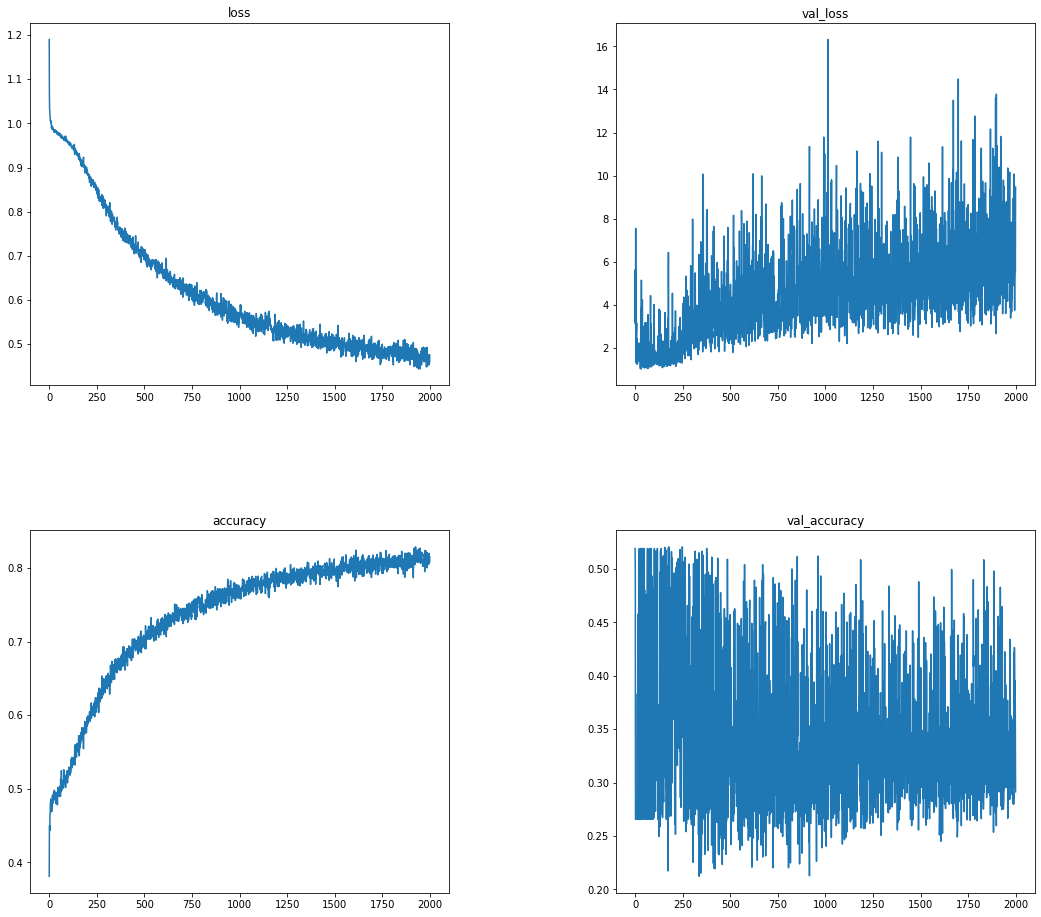

In [11]:
history_dict = history.history
history_dict.keys()

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(2, 2, 1)
plt.title('loss')
plt.plot(history_dict['loss'])
plt.subplot(2, 2, 2)
plt.title('val_loss')
plt.plot(history_dict['val_loss'])
plt.subplot(2, 2, 3)
plt.title('accuracy')
plt.plot(history_dict['accuracy'])
plt.subplot(2, 2, 4)
plt.title('val_accuracy')
plt.plot(history_dict['val_accuracy'])

plt.show()

(array([ 527.,    0.,    0.,    0.,    0.,  427.,    0.,    0.,    0.,
        1030.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

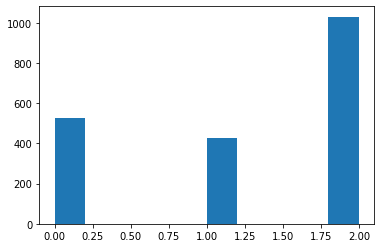

In [12]:
labels = np.argmax(Y_test, axis=1)

plt.hist(labels)

(array([1692.,    0.,    0.,    0.,    0.,  122.,    0.,    0.,    0.,
         170.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

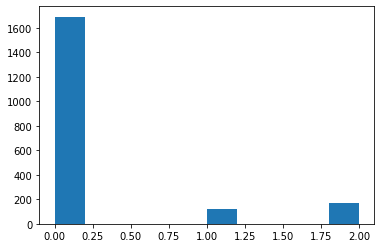

In [13]:
preds = model.predict(np.array(X_test))

plt.hist(np.argmax(preds, axis=1))

In [14]:
pred_down_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 1])
print('pred_down_while_steady: ', pred_down_while_steady)

pred_steady_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 1])
print('pred_steady_while_steady: ', pred_steady_while_steady)

pred_up_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 1])
print('pred_up_while_steady: ', pred_up_while_steady)

pred_down_while_steady:  359
pred_steady_while_steady:  34
pred_up_while_steady:  34


In [15]:
pred_down_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 0])
print('pred_down_while_down: ', pred_down_while_down)

pred_steady_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 0])
print('pred_steady_while_down: ', pred_steady_while_down)

pred_up_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 0])
print('pred_up_while_down: ', pred_up_while_down)

pred_down_while_down:  447
pred_steady_while_down:  41
pred_up_while_down:  39


In [16]:
pred_down_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 2])
print('pred_down_while_up: ', pred_down_while_up)

pred_steady_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 2])
print('pred_steady_while_up: ', pred_steady_while_up)

pred_up_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 2])
print('pred_up_while_up: ', pred_up_while_up)

pred_down_while_up:  886
pred_steady_while_up:  47
pred_up_while_up:  97
